In [30]:
import numpy as np
import astropy
from astropy.io import ascii
from astropy.table import Table
import scipy.linalg as la 
import pandas as pd     
import requests
import uncertainties
import matplotlib.pyplot as plt
import astropy.constants as const
import astropy.units as u
import json
import os
from scipy.optimize import curve_fit
import time

In [31]:
from matplotlib import rc
# Default properties:
# rc('text', usetex=True)
rc('font', family='serif')
#rc('font', serif='palatino')
#rc('font', weight='bolder')
rc('mathtext', default='sf')
rc("lines", markeredgewidth=2)
rc("lines", linewidth=3)
rc('axes', labelsize=30)
rc("axes", linewidth=2)
rc('xtick', labelsize=28)
rc('ytick', labelsize=28)
rc('legend', fontsize=20)
rc('xtick.major', pad=8)
rc('ytick.major', pad=8)
rc('xtick.major', size=13)
rc('ytick.major', size=13)
rc('xtick.major', width=3)
rc('ytick.major', width=3)
rc('xtick.minor', size=7)
rc('ytick.minor', size=7)
rc('xtick.minor', width=3)
rc('ytick.minor', width=3)

In [32]:
header = ["Exclusion Code",
            "D",
            "G",
            "Galaxy ID",
            "m-M",
            "err",
            "D (Mpc)",
            "Method",
            "REFCODE",
            "SN ID",
            "redshift (z)",
            "Hubble const.",
            "Adopted LMC modulus",
            "Date (Yr. - 1980)", 
            "Notes"]
ned_data = pd.read_csv("./NED30.5.1-D-17.1.2-20200415.csv", names=header, skiprows=13)

In [33]:
np.unique(ned_data['Method'])

array(['AGB', 'AGN time lag', 'B Stars', 'BCG', 'BL Lac Luminosity',
       'Black Hole', 'Blue Supergiant', 'Brightest Stars', 'CMD',
       'CO ring diameter', 'Carbon Stars', 'Cepheids', 'D-Sigma',
       'Delta Scuti', 'Diameter', 'Dwarf Ellipticals',
       'Dwarf Galaxy Diameter', 'Eclipsing Binary', 'FGLR', 'FP',
       'Faber-Jackson', 'G Lens', 'GC FP', 'GC K vs. (J-K)', 'GC SBF',
       'GC radius', 'GCLF', 'GRB', 'GeV TeV ratio',
       'Grav. Stability Gas. Disk', 'Grav. Wave',
       'H I + optical distribution', 'HII LF', 'HII region diameter',
       'Horizontal Branch', 'IRAS', 'Jet Proper Motion',
       'L(H{beta})-{sigma}', 'LSB galaxies', 'M Stars', 'Magnitude',
       'Maser', 'Mass Model', 'Miras', 'Novae', 'OB Stars',
       'Orbital Mech.', 'PAGB Stars', 'PNLF', 'Proper Motion',
       'Quasar spectrum', 'RR Lyrae', 'RSV Stars', 'RV Stars',
       'Radio Brightness', 'Red Clump', 'Ring Diameter',
       'S Doradus Stars', 'SBF', 'SGRB', 'SNII optical', 'SNII rad

In [34]:
def getGalInfo(galname):
    # res_headers = {
    #     'Content-type': 'application/json',
    # }
    res_data = {
        'json': '{"name":{"v": "%s"}}' % galname
    }
    res = requests.post('https://ned.ipac.caltech.edu/srs/ObjectLookup', data=res_data)
    return res.json()

In [35]:
getGalInfo('NGC 4047')

{'QueryTime': 'Tue Dec  7 01:40:31 2021',
 'Copyright': '(C) 2021 California Institute of Technology',
 'Version': '2.1',
 'Supplied': 'NGC 4047',
 'NameResolver': 'NED-NNS',
 'Interpreted': {'Name': 'NGC 4047'},
 'Preferred': {'Name': 'NGC 4047',
  'Position': {'RA': 180.7111688,
   'Dec': 48.63620306,
   'UncSemiMajor': 0.0001388888889,
   'UncSemiMinor': 0.0001388888889,
   'PosAngle': 0.0,
   'RefCode': '2007SDSS6.C...0000:'},
  'ObjType': {'Value': 'G', 'RefCode': None},
  'Redshift': {'Value': 0.011439533,
   'Uncertainty': 9.101943e-06,
   'RefCode': '2016SDSSD.C...0000:',
   'QualityFlag': 'SPEC'}},
 'StatusCode': 100,
 'ResultCode': 3}

In [36]:
def mod2dist(distance_modulus):
    return 10**(distance_modulus /5)*10 / 1e6 # in unit Mpc

## Pick three methods to calculate the H_0 and then compare them for uncertainty analysis

Calculation method
$$v_r = cz$$
$$v_r = H_0 D$$
$$H_0 = \frac{cz}{D}$$

In [37]:
bh_lum_mass_relation = ned_data[ned_data["Method"] == "Black Hole"]

In [38]:
trgb_method = ned_data[ned_data["Method"] == "TRGB"]

In [39]:
if not os.path.exists('./bh_lm_reshift.json'):
    bh_host_info = {}
    for index, row in bh_lum_mass_relation.iterrows():
        try:
            gal_info = getGalInfo(row["Galaxy ID"])["Preferred"]
        except:
            print(row["Galaxy ID"], "no data")
            continue
        redshift = gal_info["Redshift"]["Value"] 
        z_err = gal_info["Redshift"]["Uncertainty"]
        paper_reference = gal_info["Redshift"]["RefCode"]
        if redshift is None:
            print(row["Galaxy ID"], " redshift is null")
            continue
        bh_host_info[row["Galaxy ID"]] = (redshift, z_err, paper_reference)
        time.sleep(1)
    with open("bh_lm_reshift.json", "w") as fout:
        json.dump(bh_host_info, fout)
else:
    with open("./bh_lm_reshift.json", "r") as fread:
        bh_host_info = json.load(fread)

In [40]:
if not os.path.exists('./trgb_reshift.json'):
    trgb_host_info = {}
    for index, row in trgb_method.iterrows():
        try:
            gal_info = getGalInfo(row["Galaxy ID"])["Preferred"]
        except:
            print(row["Galaxy ID"], "no data")
            continue
        redshift = gal_info["Redshift"]["Value"] 
        z_err = gal_info["Redshift"]["Uncertainty"]
        paper_reference = gal_info["Redshift"]["RefCode"]
        if redshift is None:
            print(row["Galaxy ID"], " redshift is null")
            continue
        trgb_host_info[row["Galaxy ID"]] = (redshift, z_err, paper_reference)
        time.sleep(1)
    with open("trgb_reshift.json", "w") as fout:
        json.dump(trgb_host_info, fout)
else:
    with open("./trgb_reshift.json", "r") as fread:
        trgb_host_info = json.load(fread)

In [41]:
from uncertainties import unumpy as unp

In [42]:
# plt.figure(figsize=(8, 6))
bh_lm_vr = []
bh_lm_d = []
bh_lm_err_vr = []
bh_lm_err_d = []
for index, row in bh_lum_mass_relation.iterrows():
    # print(bh_host_info[row["Galaxy ID"]][0])
    if row["Galaxy ID"] not in bh_host_info.keys():
        print("not plot %s" % row["Galaxy ID"])
        continue
    u_dist = mod2dist(unp.uarray(row["m-M"], row["err"]))
    bh_lm_d.append(u_dist.n)
    bh_lm_err_d.append(u_dist.s)
    bh_lm_vr.append(const.c.to(u.km/u.s) * bh_host_info[row["Galaxy ID"]][0])
    bh_lm_err_vr.append(const.c.to(u.km/u.s) * bh_host_info[row["Galaxy ID"]][1])
bh_lm_d = np.array(bh_lm_d)
bh_lm_err_d = np.array(bh_lm_err_d)
bh_lm_vr = np.array([i.value for i in bh_lm_vr])
bh_lm_err_vr = np.array([i.value for i in bh_lm_err_vr])

not plot omega Cen


In [43]:
# plt.figure(figsize=(8, 6))
trgb_d = []
trgb_vr = []
trgb_err_vr = []
trgb_err_d = []
max_paper = None
max_num = 0
for paper in trgb_method['REFCODE']:
    if max_num < sum(trgb_method['REFCODE'] == paper):
        max_num = sum(trgb_method['REFCODE'] == paper)
        max_paper = paper
trgb_method_paper = trgb_method[trgb_method['REFCODE'] == max_paper]
print(max)
for index, row in trgb_method_paper.iterrows():
    # print(bh_host_info[row["Galaxy ID"]][0])
    # if 3.35 < row["D (Mpc)"] and  row["D (Mpc)"] < 3.8:
    #     continue
    if row["Galaxy ID"] not in trgb_host_info.keys():
        # print("not plot %s" % row["Galaxy ID"])
        continue
    # 3 sigma cut
    if trgb_host_info[row["Galaxy ID"]][0] < 3 * trgb_host_info[row["Galaxy ID"]][1]:
        # print(index, row["Galaxy ID"], "rejected by 3 sigma cut")
        continue
    if row["D (Mpc)"] < 10 and (const.c.to(u.km/u.s) * trgb_host_info[row["Galaxy ID"]][0]).value > 3000:
        print(row)
        print(trgb_host_info[row["Galaxy ID"]][0], trgb_host_info[row["Galaxy ID"]][1], trgb_host_info[row["Galaxy ID"]][2])
    u_dist = mod2dist(unp.uarray(row["m-M"], row["err"]))
    trgb_d.append(u_dist.n)
    trgb_err_d.append(u_dist.s)
    trgb_vr.append(const.c.to(u.km/u.s) * trgb_host_info[row["Galaxy ID"]][0])
    trgb_err_vr.append(const.c.to(u.km/u.s) * trgb_host_info[row["Galaxy ID"]][1])
trgb_d = np.array(trgb_d)
trgb_err_d = np.array(trgb_err_d)
trgb_vr = np.array([i.value for i in trgb_vr])
trgb_err_vr = np.array([i.value for i in trgb_err_vr])
# plt.ylim([0, 2e3])

<built-in function max>
Exclusion Code                         NaN
D                                    94236
G                                    25985
Galaxy ID                   ESO 165- G 003
m-M                                  28.21
err                                    0.1
D (Mpc)                               4.39
Method                                TRGB
REFCODE                2013AJ....146...86T
SN ID                                  NaN
redshift (z)                           NaN
Hubble const.                         74.4
Adopted LMC modulus                    NaN
Date (Yr. - 1980)                     33.0
Notes                                  NaN
Name: 139313, dtype: object
0.0609389991 0.000669999979 1998A&AS..127..463F
Exclusion Code                         NaN
D                                    94400
G                                    26114
Galaxy ID                          KK 0197
m-M                                  27.92
err                                    0

In [44]:
def hubble(d, H0):
    return H0 * d

In [45]:
# num_max = 0
# max_paper = None
# for paper in np.unique(trgb_method["REFCODE"]):
#     if num_max < sum(trgb_method["REFCODE"] == paper):
#         num_max = sum(trgb_method["REFCODE"] == paper)
#         max_paper = paper

[73.36355989] [[253.69763793]]


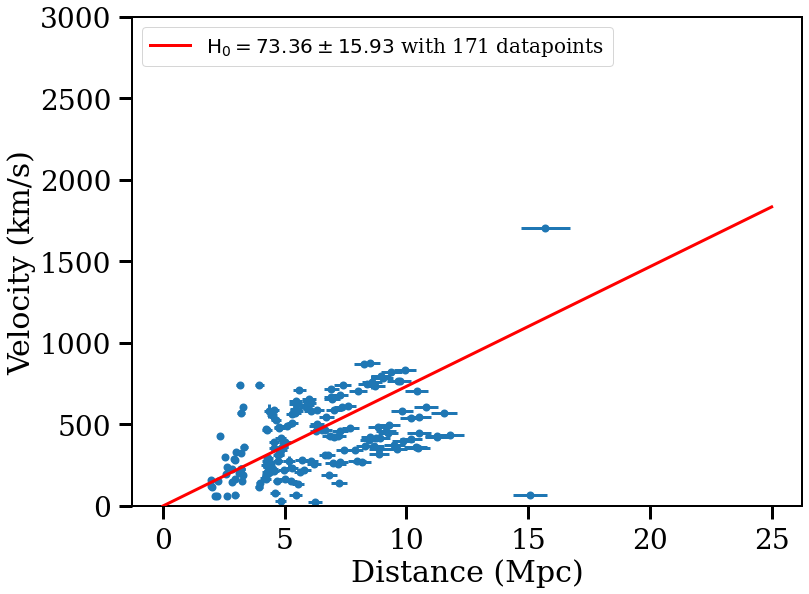

In [46]:
remove_value = (3.35 < trgb_d) & (trgb_d < 3.9) 
dist_cut = (trgb_d > 3 * trgb_err_d)
z_cut = (trgb_vr > 3 * trgb_err_vr)
mask =   (trgb_d > 1.5) & ~remove_value & dist_cut & z_cut
trgb_popt, trgb_pcov = curve_fit(hubble, trgb_d[mask], trgb_vr[mask])
print(trgb_popt, trgb_pcov)
plt.figure(figsize=(12, 9))
plt.errorbar(trgb_d[mask], trgb_vr[mask], fmt='o', yerr=trgb_err_vr[mask], xerr=trgb_err_d[mask])
xarr = np.linspace(0, 25)
plt.plot(xarr, trgb_popt * xarr, "r", label=r"$H_0=%.2f \pm %.2f$ with %s datapoints" % (trgb_popt, np.sqrt(trgb_pcov), sum(mask)), zorder=1e10)
plt.xlabel("Distance (Mpc)")
plt.ylabel("Velocity (km/s)")
plt.legend(loc="upper left")
# plt.xlim([0, 450])
plt.ylim([0, 3000])
plt.savefig("trbg_single_paper.pdf", bbox_inches="tight")

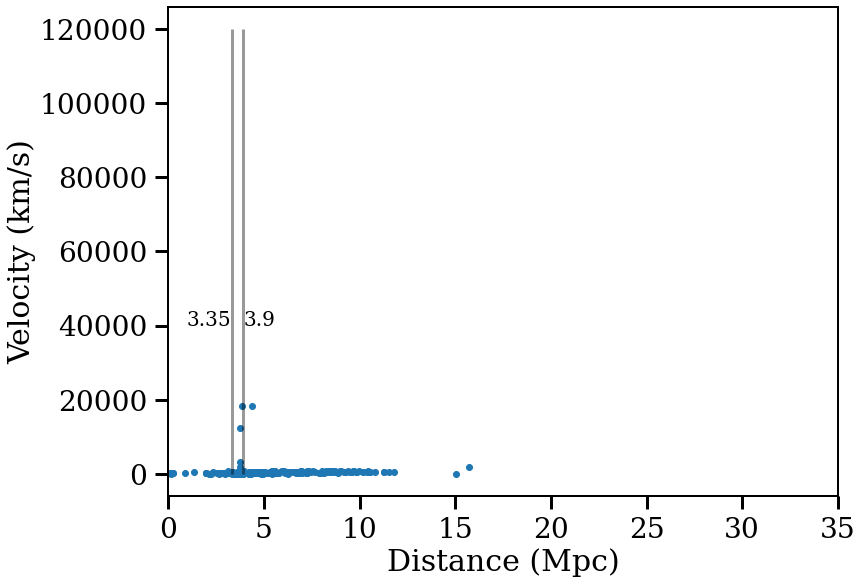

In [47]:
plt.figure(figsize=(12, 9))
plt.scatter(trgb_d, trgb_vr) #fmt='o', yerr=trgb_err_vr, xerr=trgb_err_d)
# xarr = np.linspace(0, 40)
# plt.plot(xarr, trgb_popt * xarr, "r", label=r"$H_0=%.2f \pm %.2f$ with %s datapoints" % (trgb_popt, np.sqrt(trgb_pcov), sum(mask)))
plt.vlines([3.35, 3.9], ymin=0, ymax=120000, colors="k", zorder=100, alpha=0.4)
plt.text(3.30, 40000, "3.35", fontsize=20, horizontalalignment='right')
plt.text(3.93, 40000, "3.9", fontsize=20, horizontalalignment='left')
plt.xlabel("Distance (Mpc)")
plt.ylabel("Velocity (km/s)")
plt.xlim([0, 35])
# plt.ylim([0, 3000])
plt.savefig("trgb_single_paper_valley.pdf", bbox_inches="tight")

[60.07198008] [[5.92604063]]


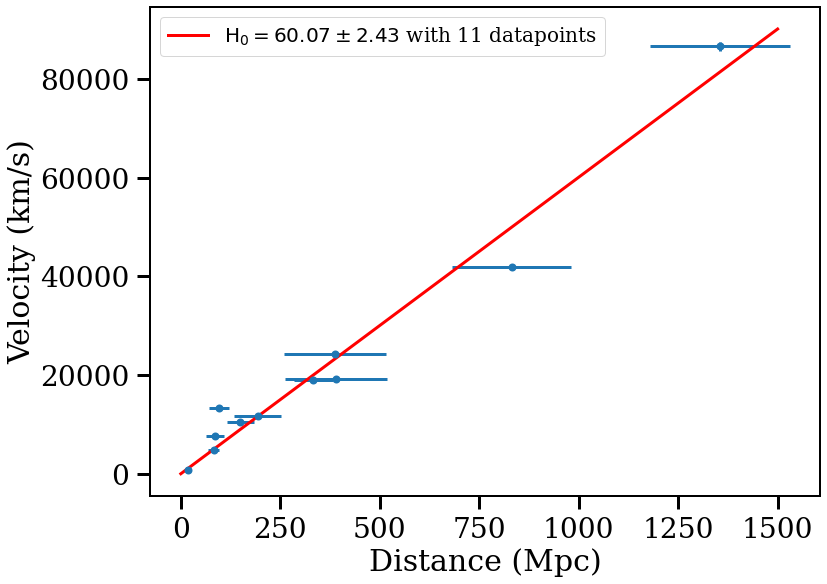

In [48]:
dist_cut = bh_lm_d > 3* bh_lm_err_d
z_cut = bh_lm_vr > 3* bh_lm_err_vr
mask = dist_cut & z_cut & (bh_lm_d > 1.5)
bh_lm_popt, bh_lm_pcov = curve_fit(hubble, bh_lm_d[mask], bh_lm_vr[mask])
print(bh_lm_popt, bh_lm_pcov)
plt.figure(figsize=(12, 9))
plt.errorbar(bh_lm_d[mask], bh_lm_vr[mask], fmt='o', yerr=bh_lm_err_vr[mask], xerr=bh_lm_err_d[mask])
xarr = np.linspace(0, 1500)
plt.plot(xarr, bh_lm_popt * xarr, "r", label=r"$H_0 = %.2f \pm %.2f$ with %s datapoints" % (bh_lm_popt, np.sqrt(bh_lm_pcov), sum(mask)))
plt.xlabel("Distance (Mpc)")
plt.ylabel("Velocity (km/s)")
plt.legend(loc="upper left")
# plt.xlim([0, 450])
# plt.ylim([0, 3000])
plt.savefig("bh_lm.pdf", bbox_inches="tight")

In [49]:
bh_lm_d

array([  85.90135215,  831.7637711 ,   31.33285724,  114.28783348,
        390.84089579,  149.27944096,   95.4992586 ,   17.86487575,
        387.25764492,  100.92528861,  154.17004529,  193.1968317 ,
         61.94410751, 1355.18941235,  332.65955329,   82.4138115 ])

In [50]:
snIa = ned_data[ned_data["Method"] == "SNIa"]
snIa_sdss = snIa[snIa['REFCODE'] == '2018PASP..130f4002S']

In [51]:
if not os.path.exists('./snIa_reshift.json'):
    snIa_host_info = {}
    for index, row in snIa_sdss.iterrows():
        try:
            gal_info = getGalInfo(row["Galaxy ID"])["Preferred"]
        except:
            print(row["Galaxy ID"], "no data")
            continue
        redshift = gal_info["Redshift"]["Value"] 
        z_err = gal_info["Redshift"]["Uncertainty"]
        paper_reference = gal_info["Redshift"]["RefCode"]
        if redshift is None:
            print(row["Galaxy ID"], " redshift is null")
            continue
        snIa_host_info[row["Galaxy ID"]] = (redshift, z_err, paper_reference)
        time.sleep(1)
    with open("snIa_reshift.json", "w") as fout:
        json.dump(bh_host_info, fout)
else:
    with open("./snIa_reshift.json", "r") as fread:
        snIa_host_info = json.load(fread)

In [52]:
u_dist = mod2dist(unp.uarray(snIa_sdss["m-M"], snIa_sdss["err"]))
snIa_sdss_vr_data = const.c.to(u.km/u.s) * snIa_sdss["redshift (z)"]
snIa_sdss_d = unp.nominal_values(u_dist)
snIa_sdss_err_d = unp.std_devs(u_dist)


[56.14727409] [[0.02605979]]


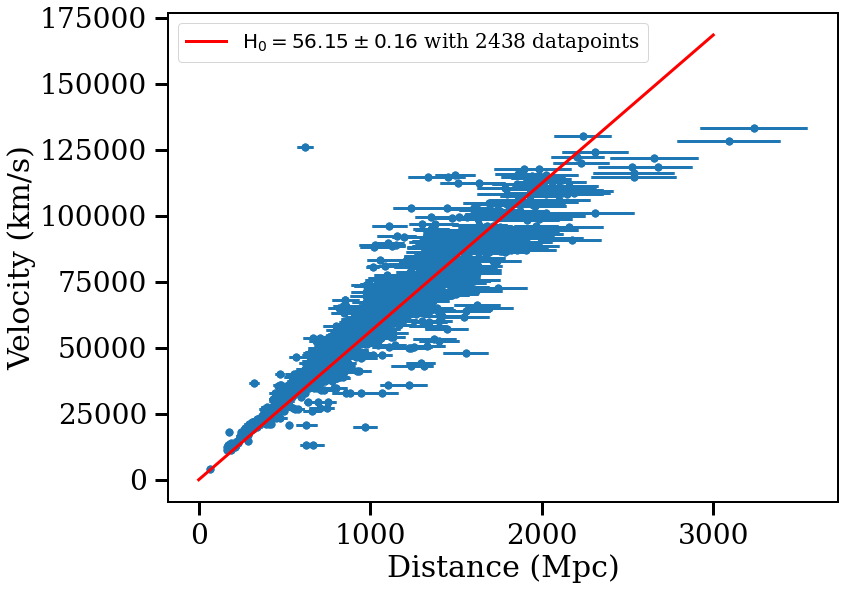

In [53]:
plt.figure(figsize=(12, 9))
dist_cut = (snIa_sdss_d > 10*snIa_sdss_err_d)
mask = (1.5 < snIa_sdss_d) & dist_cut
plt.errorbar(snIa_sdss_d[mask], snIa_sdss_vr_data[mask], fmt='o', xerr=snIa_sdss_err_d[mask])
snIa_popt, snIa_pcov = curve_fit(hubble, snIa_sdss_d[mask], snIa_sdss_vr_data[mask])
print(snIa_popt, snIa_pcov)
xarr = np.linspace(0, 3000)
plt.plot(xarr, snIa_popt * xarr, "r", label=r"$H_0=%.2f \pm %.2f$ with %s datapoints" % (snIa_popt, np.sqrt(snIa_pcov), sum(mask)), zorder=1e10)
plt.xlabel("Distance (Mpc)")
plt.ylabel("Velocity (km/s)")
plt.legend(loc="upper left")
# plt.xlim([0, 450])
plt.savefig("sne1a.pdf", bbox_inches="tight")

[73.36355989] [[253.69763793]]
[60.07198008] [[5.92604063]]
[56.14727409] [[0.02605979]]


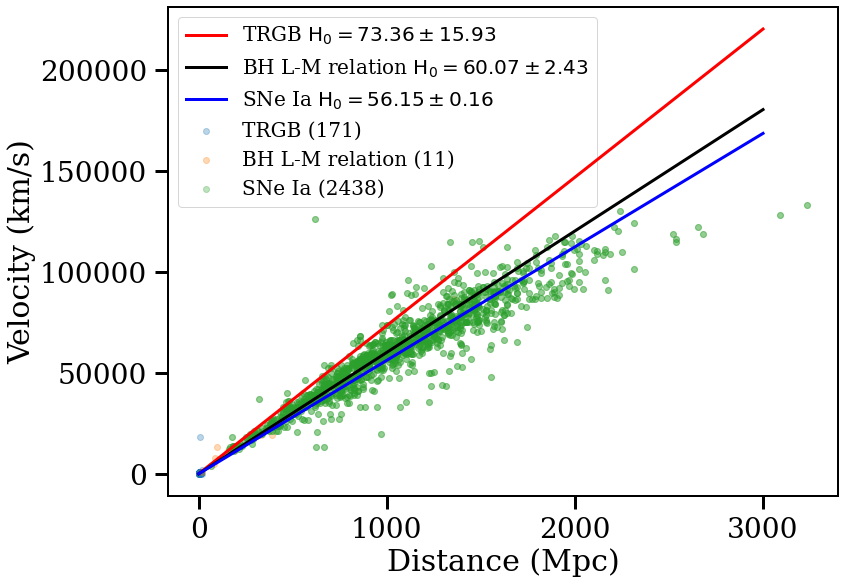

In [54]:
plt.figure(figsize=(12, 9))
remove_value = (3.35 < trgb_d) & (trgb_d < 3.9) 
dist_cut = (trgb_d > 3 * trgb_err_d)
z_cut = (trgb_vr > 3 * trgb_err_vr)
mask =   (trgb_d > 1.5) & ~remove_value & dist_cut & z_cut
trgb_popt, trgb_pcov = curve_fit(hubble, trgb_d[mask], trgb_vr[mask])
print(trgb_popt, trgb_pcov)
plt.scatter(trgb_d[mask], trgb_vr[mask], alpha=0.3, label="TRGB (%s)" % sum(mask))
xarr = np.linspace(0, 3000)
plt.plot(xarr, trgb_popt * xarr, "r", label=r"TRGB $H_0=%.2f \pm %.2f$" % (trgb_popt, np.sqrt(trgb_pcov)), zorder=1e10)


dist_cut = bh_lm_d > 3* bh_lm_err_d
z_cut = bh_lm_vr > 3* bh_lm_err_vr
mask = dist_cut & z_cut & (bh_lm_d > 1.5)
bh_lm_popt, bh_lm_pcov = curve_fit(hubble, bh_lm_d[mask], bh_lm_vr[mask])
print(bh_lm_popt, bh_lm_pcov)

plt.scatter(bh_lm_d[mask], bh_lm_vr[mask], alpha=0.3, label="BH L-M relation (%s)" % sum(mask))

plt.plot(xarr, bh_lm_popt * xarr, "k", label=r"BH L-M relation $H_0 = %.2f \pm %.2f$" % (bh_lm_popt, np.sqrt(bh_lm_pcov)), zorder=1e10)

dist_cut = (snIa_sdss_d > 10*snIa_sdss_err_d)
mask = (1.5 < snIa_sdss_d) & dist_cut
plt.scatter(snIa_sdss_d[mask], snIa_sdss_vr_data[mask], alpha=0.3, label="SNe Ia (%s)" % sum(mask))
snIa_popt, snIa_pcov = curve_fit(hubble, snIa_sdss_d[mask], snIa_sdss_vr_data[mask])
print(snIa_popt, snIa_pcov)

plt.plot(xarr, snIa_popt * xarr, "b", label=r"SNe Ia $H_0=%.2f \pm %.2f$" % (snIa_popt, np.sqrt(snIa_pcov)), zorder=1e10)

plt.xlabel("Distance (Mpc)")
plt.ylabel("Velocity (km/s)")
plt.legend(loc="upper left")
plt.savefig("all_together_single_trgb.pdf", bbox_inches="tight")

In [55]:
trgb_host_info

{'WLM': [-0.000408, 4e-06, '2015AJ....149..180O'],
 'Andromeda XVIII': [-0.001108, 9e-06, '2013MNRAS.430..971W'],
 'NGC 7814': [0.003506, 5e-06, '2005ApJS..160..149S'],
 'ESO 409-IG 015': [0.002459, 2e-05, '2006HIPAS.C...0000:'],
 'AGC 748778': [0.0008605953656, 5.003461428e-06, '2016ApJ...832...85T'],
 'Andromeda XX': [-0.001522, 1.1e-05, '2013MNRAS.430..971W'],
 'ESO 349- G 031': [0.000757, 7e-06, '2007AJ....134.1849W'],
 'NGC 0045': [0.00155799999, 9.99999997e-07, '2003A&A...408..465M'],
 'Pisces A': [0.0007832084955, 3.335640952e-07, '2019AJ....157...81O'],
 'NGC 0055': [0.0004369689647, 6.671281904e-06, '2017MNRAS.468..492P'],
 'NGC 0059': [0.00120699999, 3.30000003e-05, '2006AJ....131..325B'],
 'ESO 410- G 005': [0.000530000019, 7.0000001e-06, '2009AJ....137.3038B'],
 'Andromeda XIX': [-0.000371, 4e-06, '2013MNRAS.430..971W'],
 'IC 0010': [-0.001161, 3e-06, '1999ApJS..121..287H'],
 'Andromeda XXVI': [-0.000869, 1.3e-05, '2013MNRAS.430..971W'],
 'LEDA 3097727': [0.0, 0.0, '2017ApJ